<h1 align="center">
Multi-Task Bayesian Optimization Benchmark


Bulk Modulus to Experimental Harndness
</h1>

<h3 align="center">
Daniel Persaud
</h3>

<p align="center">
October 2024
</p>

<h2 align="center">
Downloading Package & Import Dependencies
</h2>


In [1]:
# %pip install baybe                                      # download or update as necessary
# %conda install pytorch torchvision -c pytorch -y        # OSX only
# %pip install ax-platform==0.4.3                         # 

In [2]:
# IMPORT DEPENDENCIES------------------------------------------------------------------------------
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
from baybe.campaign import Campaign
from baybe.objectives import SingleTargetObjective
from baybe.parameters import NumericalDiscreteParameter, TaskParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios
from baybe.targets import NumericalTarget
from baybe.recommenders import RandomRecommender
from baybe.utils.random import set_random_seed

from ax.core.observation import ObservationFeatures
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.modelbridge.transforms.task_encode import TaskEncode
from ax.modelbridge.transforms.unit_x import UnitX
from ax.service.ax_client import AxClient, ObjectiveProperties
lstTransforms = [TaskEncode, UnitX]

set_random_seed(42)

# add the target data
def preTrainAx(
        axClient: AxClient,
        dfLookupTable: pd.DataFrame,
        intN: int = 1,
        lstColumnsToDrop: list[str] = ["Target"],
        strObjectiveName: str = "Target"
    ) -> AxClient:
    '''
    randomly select n data points from dfLookupTable_target and add them to the experiment

    arguments
    ----------

    intN : int
        the number of data points to add to the experiment

    dfLookupTable : pd.DataFrame
        the lookup table to sample from

    ax_client : AxClient
        the ax client to add the data to

    returns
    -------

    ax_client : AxClient
        the ax client with the data added
    '''

    # randomly select n data points from dfLookupTable_target
    dfTarget_temp = dfLookupTable.sample(intN)
    
    for _, row in dfTarget_temp.iterrows():
        # get the row as a dictionary
        dictRow = row.to_dict()
        # drop every string in lstColumnsToDrop
        dictRow = {k: v for k, v in dictRow.items() if k not in lstColumnsToDrop}
        # add the row to the experiment
        _, trial_index = axClient.attach_trial(parameters=dictRow)
        # complete the trial
        axClient.complete_trial(trial_index=trial_index, raw_data={"Objective": row["Target"]})

<h2 align="center">
Import and Preprocess Data
</h2>

In [3]:
# LOAD DATA----------------------------------------------------------------------------------------

# get the path to the directory before the current directory
strHomeDir = os.path.dirname(os.getcwd())

dfMP = pd.read_csv(
    os.path.join(strHomeDir, "data", "processed", "mp_bulkModulus_goodOverlap.csv"), index_col=0
)

dfExp = pd.read_csv(
    os.path.join(strHomeDir, "data", "processed", "exp_hardness_goodOverlap.csv"), index_col=0
)

lstElementCols = dfExp.columns.to_list()[4:]

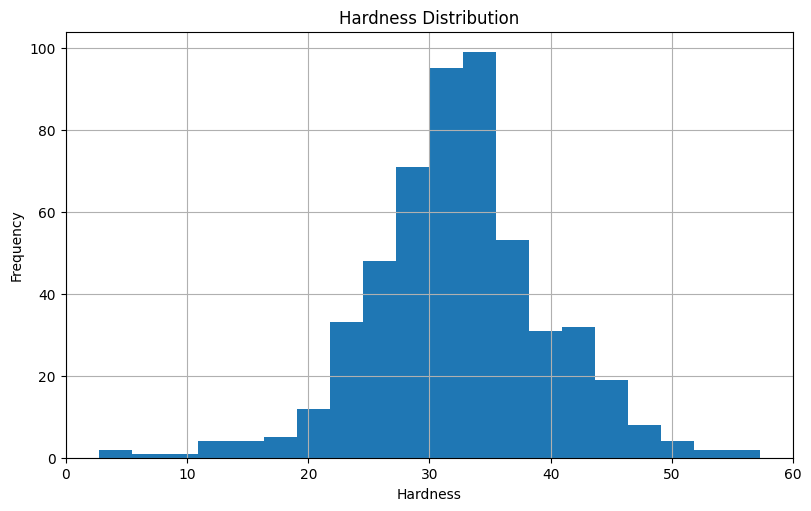

In [4]:
# ----- MAKE A HISTOGRAM OF THE HARDNESS VALUE -----

# initialize a subplot with 1 row and 1 column
fig, ax = plt.subplots(
    1, 1,
    figsize=(8, 5),
    facecolor='w',
    edgecolor='k',
    constrained_layout = True
)

# plot a histogram of the hardness values
ax.hist(dfExp["hardness"], bins=20)

# add a title, x-aixs label, and y-axis label
ax.set_xlabel("Hardness")
ax.set_ylabel("Frequency")
ax.set_title("Hardness Distribution")

# add a grid
ax.grid()

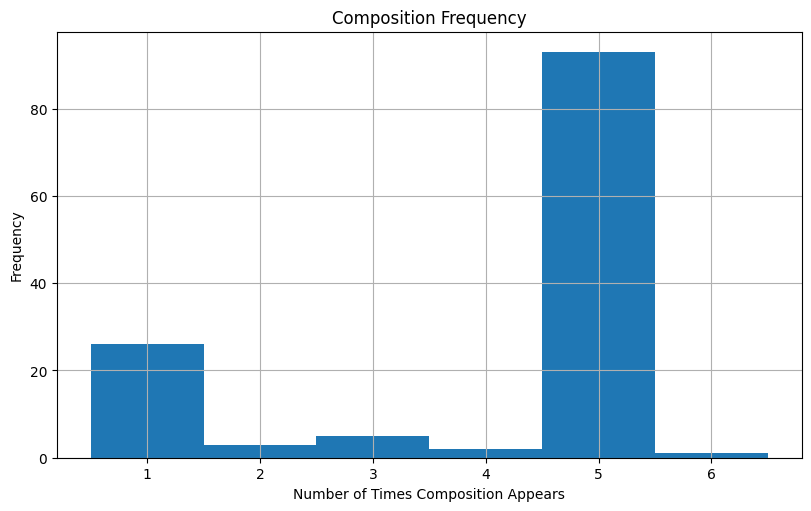

In [5]:
# ----- FIND THE DUPLICATE COMPOSITIONS -----

# for each unique composition in dfExp, count the number of times it appears
srCompositionCounts = dfExp["composition"].value_counts()

# initialize a subplot with 1 row and 1 column
fig, ax = plt.subplots(
    1, 1,
    figsize=(8, 5),
    facecolor='w',
    edgecolor='k',
    constrained_layout = True
)

# plot a histogram of srCompositionCounts where the x-axis is the number of times a composition appears and the y-axis is the frequency
lstHeight, lstBins, contPatches = ax.hist(srCompositionCounts, bins=6)

# calculate the center of each bin
lstBinCenters = 0.5 * (lstBins[:-1] + lstBins[1:])
# set the x-ticks to the bin centers
ax.set_xticks(lstBinCenters)
# create custom labels based on the bin ranges or integer values
# for instance, using the left edge of each bin as a label
lstTickLabels = [f"{int(lstBins[i+1])}" for i in range(len(lstBins)-1)]
# set the custom tick labels
ax.set_xticklabels(lstTickLabels)


# add a title, x-aixs label, and y-axis label
ax.set_title("Composition Frequency")
ax.set_xlabel("Number of Times Composition Appears")
ax.set_ylabel("Frequency")

# add a grid
ax.grid(True)

In [6]:
# ----- FUTHER CLEAN THE DATA BASED ON THE EDA -----

# initialize an empty dataframe to store the integrated hardness values
dfExp_integratedHardness = pd.DataFrame()

# for each unique composition in dfExp, make a cubic spline interpolation of the hardness vs load curve
for strComposition_temp in dfExp["composition"].unique():
    # get the data for the composition
    dfComposition_temp = dfExp[dfExp["composition"] == strComposition_temp]
    # sort the data by load
    dfComposition_temp = dfComposition_temp.sort_values(by="load")
    # if there are any duplicate values for load, drop them
    dfComposition_temp = dfComposition_temp.drop_duplicates(subset="load")
    # if there are less than 5 values, continue to the next composition
    if len(dfComposition_temp) < 5:
        continue

    # make a cubic spline interpolation of the hardness vs load curve
    spSpline_temp = sp.interpolate.CubicSpline(dfComposition_temp["load"], dfComposition_temp["hardness"])
    # integrate the spline from the minimum load to the maximum load
    fltIntegral_temp = spSpline_temp.integrate(0.5, 5, extrapolate = True)

    # make a new dataframe with the lstElementCols from dfComposition_temp
    dfComposition_temp = dfComposition_temp[['strComposition', 'composition'] + lstElementCols]
    dfComposition_temp = dfComposition_temp.drop_duplicates(subset='composition')
    # add a column to dfComposition_temp called 'integratedHardness' and set all values to fltIntegral_temp
    dfComposition_temp["integratedHardness"] = fltIntegral_temp

    # append dfComposition_temp to dfExp_integratedHardness
    dfExp_integratedHardness = pd.concat([dfExp_integratedHardness, dfComposition_temp])

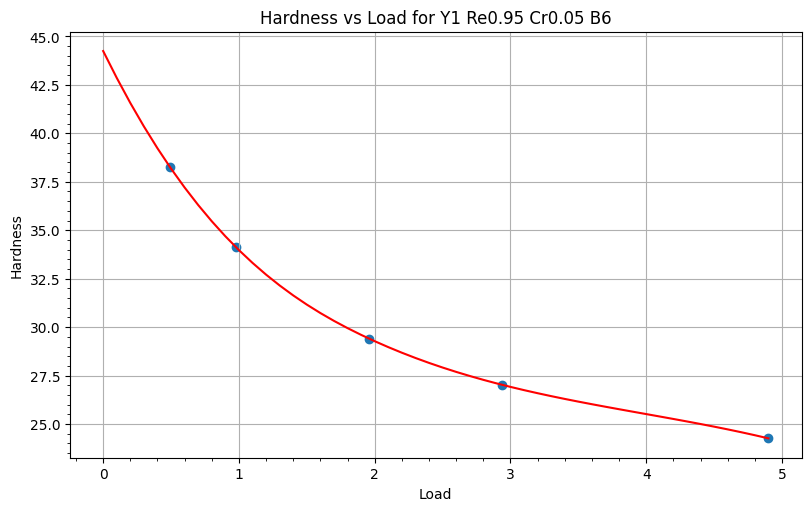

In [7]:
# ----- EXAMPLE CURVE FOR A COMPOSITION -----

# initialize a subplot with 0 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(8, 5), facecolor='w', edgecolor='k', constrained_layout = True)


# plot the hardness vs load for entries with composition Y1 Re0.95 Cr0.05 B6
ax.scatter(
    dfExp.loc[dfExp["composition"] == "Y2 Re0.95 Cr0.05 B6"]["load"],
    dfExp.loc[dfExp["composition"] == "Y2 Re0.95 Cr0.05 B6"]["hardness"]
)

# make a cubic spline interpolation of the hardness vs load curve
spSpline = sp.interpolate.CubicSpline(
    dfExp.loc[dfExp["composition"] == "Y2 Re0.95 Cr0.05 B6"]["load"],
    dfExp.loc[dfExp["composition"] == "Y2 Re0.95 Cr0.05 B6"]["hardness"]
)

# make a range of values from -1.5 to 5 with steps of 0.1
lstX = np.arange(0, 5, 0.1)
# evaluate the spline at the values in lstX
lstY = spSpline(lstX)

# plot the spline
ax.plot(lstX, lstY, color='r')

# add a title, x-aixs label, and y-axis label
ax.set_title("Hardness vs Load for Y1 Re0.95 Cr0.05 B6")
ax.set_xlabel("Load")
ax.set_ylabel("Hardness")


# add a grid
ax.grid(True)
# add minor ticks
ax.minorticks_on()

In [8]:
# ----- CREATE DATAFRAMES FOR THE SEARCH SPACE -----

# ----- TARGET FUNCTION (INTEGRATED HARDNESS) -----
# make a dataframe for the task function (integrated hardness)
dfSearchSpace_target = dfExp_integratedHardness[lstElementCols]
# add a column to dfSearchSpace_task called 'Function' and set all values to 'taskFunction'
dfSearchSpace_target["Function"] = "targetFunction"

# make a lookup table for the task function (integrate hardness) - add the 'integratedHardness' column from dfExp to dfSearchSpace_task
dfLookupTable_target = pd.concat([dfSearchSpace_target, dfExp_integratedHardness["integratedHardness"]], axis=1)
# make the 'integrate hardness' column the 'Target' column
dfLookupTable_target = dfLookupTable_target.rename(columns={"integratedHardness":"Target"})

# ----- SOURCE FUNCTION (VOIGT BULK MODULUS) -----
# make a dataframe for the source function (voigt bulk modulus)
dfSearchSpace_source = dfMP[lstElementCols]
# add a column to dfSearchSpace_source called 'Function' and set all values to 'sourceFunction'
dfSearchSpace_source["Function"] = "sourceFunction"

# make a lookup table for the source function (voigt bulk modulus) - add the 'vrh' column from dfMP to dfSearchSpace_source
dfLookupTable_source = pd.concat([dfSearchSpace_source, dfMP["vrh"]], axis=1)
# make the 'vrh' column the 'Target' column
dfLookupTable_source = dfLookupTable_source.rename(columns={"vrh": "Target"})

# concatenate the two dataframes
dfSearchSpace = pd.concat([dfSearchSpace_target, dfSearchSpace_source])

/var/folders/gv/g01yxshj0r52f0yqw_kjpvk00000gn/T/ipykernel_69772/4013512175.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSearchSpace_target["Function"] = "targetFunction"
/var/folders/gv/g01yxshj0r52f0yqw_kjpvk00000gn/T/ipykernel_69772/4013512175.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSearchSpace_source["Function"] = "sourceFunction"


<h2 align="center">
Baybe
</h2>

In [9]:
# ----- GENERATE THE SEARCH SPACE -----

lstParameters_bb = []

# for each column in dfSearchSpace except the last one, create a NumericalDiscreteParameter
for strCol_temp in dfSearchSpace.columns[:-1]:
    # create a NumericalDiscreteParameter
    bbParameter_temp = NumericalDiscreteParameter(
        name=strCol_temp,
        values=np.unique(dfSearchSpace[strCol_temp]),
        tolerance=0.0,
    )
    # append the parameter to the list of parameters
    lstParameters_bb.append(bbParameter_temp)

# create a TaskParameter
bbTaskParameter = TaskParameter(
    name="Function",
    values=["targetFunction", "sourceFunction"],
    active_values=["targetFunction"],
)

# append the taskParameter to the list of parameters
lstParameters_bb.append(bbTaskParameter)

# create the search space
bbSearchSpace = SearchSpace.from_dataframe(dfSearchSpace, parameters=lstParameters_bb)

In [10]:
# ----- CREATE OPTIMIZATION OBJECTIVE -----

bbObjective = SingleTargetObjective(target=NumericalTarget(name="Target", mode="MAX"))

In [11]:
intMCIterations = 5
intDOEIterations = 20
intBatchSize = 1

# initialize a list to store the results
lstResults_bb: list[pd.DataFrame] = []

multi-task learning with different number of initial data


In [12]:
for n in (2, 4, 6, 30):
    bbCampaign_temp = Campaign(
        searchspace=bbSearchSpace,
        objective=bbObjective)
    # create a list of dataframes with n samples from dfLookupTable_source to use as initial data
    lstInitialData_temp = [dfLookupTable_source.sample(n) for _ in range(intMCIterations)]


    dfResult_bb_mtl_temp = simulate_scenarios(
        {f"{n}": bbCampaign_temp},                                                # int(100*p)
        dfLookupTable_target,
        initial_data=lstInitialData_temp,
        batch_size=intBatchSize,
        n_doe_iterations=intDOEIterations,
    )
    lstResults_bb.append(dfResult_bb_mtl_temp)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/envs/env202410_BO_dev/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
100%|##########| 5/5 [04:35<00:00, 55.02s/it]


multi-task learning with 0 initial data (baseline) **TO ADD BASELINE WITH NO TASK PARAMETER**

In [13]:
dfResult_bb_baseline = simulate_scenarios(
    {"0": Campaign(
        searchspace=bbSearchSpace,
        objective=bbObjective)},
    dfLookupTable_target,
    batch_size=intBatchSize,
    n_doe_iterations=intDOEIterations,
    n_mc_iterations=intMCIterations,
)

100%|##########| 5/5 [03:53<00:00, 46.64s/it]


random sampling as implemented by baybe

In [14]:
dfResults_bb_random = simulate_scenarios(
    {"random": Campaign(
        searchspace=bbSearchSpace,
        objective=bbObjective,
        recommender=RandomRecommender())},
    dfLookupTable_target,
    batch_size=intBatchSize,
    n_doe_iterations=intDOEIterations,
    n_mc_iterations=intMCIterations,
)

100%|##########| 5/5 [00:00<00:00, 12.84it/s]


put all the results together **ADD ARGPARSE AND ADD PATH TO SAVE RESULTS**

Text(0, 0.5, 'Target Cumulative Best - integratedHardness')

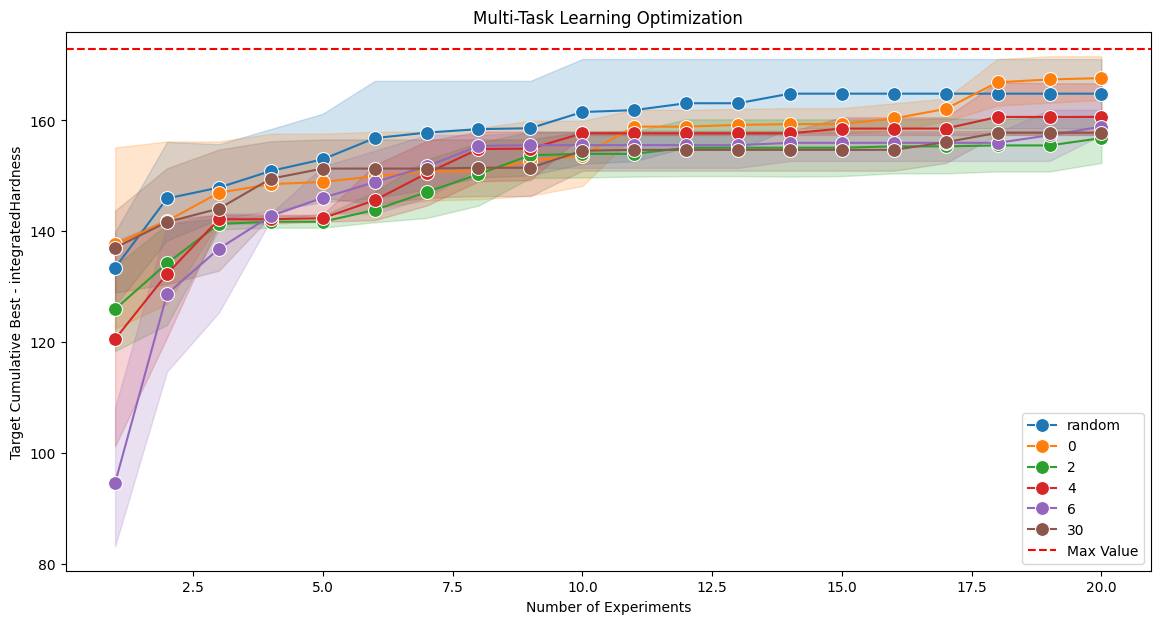

In [15]:
dfResults_bb = pd.concat([dfResults_bb_random, dfResult_bb_baseline, *lstResults_bb])
dfResults_bb.rename(columns={"Scenario": "Number of data used"}, inplace=True)
# import results
# dfResults_bb = pd.read_csv(os.path.join(strHomeDir, 'reports', 'results_integratedHardness_final.csv'),  index_col=0)

# ----- PLOT BB RESULTS -----
# intialize a subplot with 1 row and 1 column
fig, ax = plt.subplots(
    1, 1,
    figsize=(14, 7))

# plot the results
ax = sns.lineplot(
    data=dfResults_bb,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Number of data used",
)

# add a line at the maximum value
plt.axhline(y=dfLookupTable_target['Target'].max(), color='r', linestyle='--', label='Max Value')

# add a legend
plt.legend()

# add a title
plt.title("Multi-Task Learning Optimization")

# add a x-axis label
plt.xlabel("Number of Experiments")

# add a y-axis label
plt.ylabel("Target Cumulative Best - integratedHardness")

# save the figure
# plt.savefig(os.path.join(strHomeDir, 'reports', 'figures', 'multiTaskLearning_hardness.png'))


<h2 align="center">
AX
</h2>

In [16]:
# ----- GENERATE THE SEARCH SPACE -----

# make a list of dictionaries for the parameters (each dictionary is one of the elements in the list)
lstParameters_ax = [
    {
        "name": strCol_temp,
        "type": "range",
        "value_type": "float",
        "bounds": [np.unique(dfSearchSpace[strCol_temp]).min(), np.unique(dfSearchSpace[strCol_temp]).max()],
    }
    for strCol_temp in dfSearchSpace.columns[:-1]
]

# add the task parameter
lstParameters_ax.append(
    {
        "name": "Function",
        "type": "choice",
        "values": ["targetFunction", "sourceFunction"],
        "is_task": True,
        "target_value": "targetFunction",
    }
)

strSeparator = " + "
strCompositionConstraint = strSeparator.join(lstElementCols[:-1]) + " <= 1.0"

In [17]:
# ----- CREATE GENERATION STRATEGY -----

axGenerationStrategy = GenerationStrategy(
    name="MultiTaskOp",
    steps=[
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,
            max_parallelism=10,
            model_kwargs={"transforms": lstTransforms},
        ),
    ],
)

In [18]:
# initialize a dataframe to store the results
dfResults_ax = pd.DataFrame()

multi-task learning with different number of initial data


In [19]:
for n_preTrain in (2, 4, 6):
    # generate a list of 10 random integers between 0 and 100000 
    lstMCIterations = [1337, 1338, 2112, 1233, 99987]
    intMCRun = 0

    # for each value of n in lstMCIterations
    for intMC in lstMCIterations:
        np.random.seed(intMC)
        
        # initialize the ax client
        axClient = AxClient(
            generation_strategy=axGenerationStrategy,
            random_seed=intMC,
            verbose_logging=False
        )

        # create the experiment
        axClient.create_experiment(
            name="MultiTaskOp",
            parameters=lstParameters_ax,
            #parameter_constraints=[strCompositionConstraint],
            objectives={"Objective": ObjectiveProperties(minimize=False)},
        )

        # add the source data
        preTrainAx(axClient, dfLookupTable_source, n_preTrain)

        # initialize the optimization loop with 2 data points
        preTrainAx(axClient, dfLookupTable_target, 2)

        # optimize the experiment
        for i in range(intDOEIterations):
            # fit the model
            axClient.fit_model()
            axModel_temp = axClient.generation_strategy.model

            # get the observation features
            lstObservationFeatures = [
                ObservationFeatures(row.to_dict())
                for _, row in dfSearchSpace_target.iterrows()
            ]

            # get the acquisition function
            lstAquisitionFunctionValues = np.array(
                axModel_temp.evaluate_acquisition_function(
                    observation_features=lstObservationFeatures
                )
            )

            # get the index of the maximum value
            intBestID = np.argmax(lstAquisitionFunctionValues)
            dicBestRow = dfSearchSpace_target.iloc[intBestID].to_dict()

            # extract the element columns from the best row
            lstBestElementCols = {k: v for k, v in dicBestRow.items() if k in lstElementCols}

            # find the row in dfLookupTable_target that matches the best element columns
            dfBestRow = dfLookupTable_target[
                (dfLookupTable_target[lstElementCols] == pd.Series(lstBestElementCols)).all(axis=1)
            ]

            # extract the target value from the best row
            fltBestTarget = dfBestRow["Target"].values[0] if not dfBestRow.empty else None

            # add the best row to the experiment
            _, trial_index = axClient.attach_trial(parameters=dicBestRow)
            axClient.complete_trial(trial_index=trial_index, raw_data={"Objective": fltBestTarget})

        # STORE THE RESULTS

        # initialize an index for the results
        intNumTrial_temp = n_preTrain + 2

        # get the data from the experiment
        dfResults_temp = axClient.get_trials_data_frame()
        # drop the first n_preTrain trials from the dataframe
        dfResults_temp.drop(range(intNumTrial_temp), inplace=True)
        # add a another column to the dataframe called 'Num_Experiments' and set all values to trial_index - intNumTrials
        dfResults_temp["Num_Experiments"] = dfResults_temp["trial_index"] - intNumTrial_temp + 1
        # add a column to the dataframe called 'Num_MC' and set all values to n_MC
        dfResults_temp["Monte_Carlo_Run"] = intMCRun
        # add a column called 'Number of data used' and set all values to n_preTrain
        dfResults_temp["Number of data used"] = n_preTrain
        # add a column called 'Target_CumBest' and set all values to the cumulative maximum of the 'Objective' column for the entries before the current entry
        dfResults_temp["Target_CumBest"] = dfResults_temp["Objective"].cummax()

        # append dfResults_temp to dfResults_ax
        dfResults_ax = pd.concat([dfResults_ax, dfResults_temp])

        intMCRun += 1

[WARNING 10-07 22:08:34] ax.service.ax_client: Random seed set to 1337. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 10-07 22:08:34] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter Function. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/opt/anaconda3/envs/env202410_BO_dev/lib/python3.11/site-packages/ax/service/utils/instantiation.py:248: AxParameterWarning: `is_ordered` is not specified for `ChoiceParameter` "Function". Defaulting to `True`  since there are exactly two choices.. To override this behavior (or avoid this warning), specify `is_ordered` during `ChoiceParameter` construction. 

Text(0, 0.5, 'Target Cumulative Best - integratedHardness')

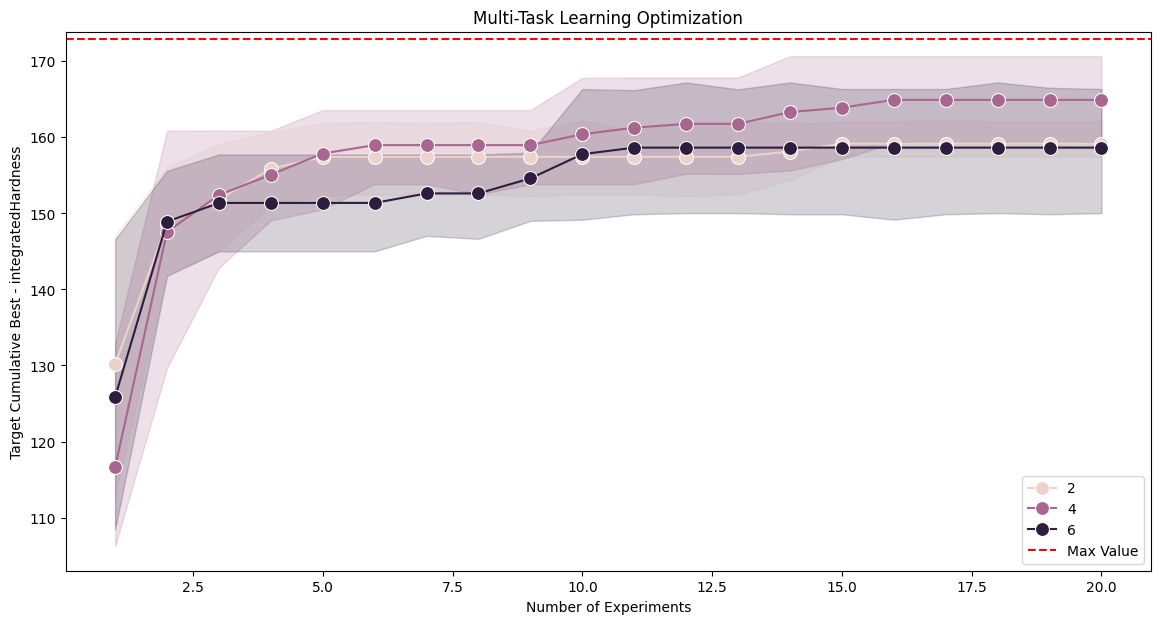

In [20]:
# ---- PLOT AX RESULTS -----

# intialize a subplot with 1 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# plot the results
ax = sns.lineplot(
    data=dfResults_ax,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Number of data used",
)

# add a line at the maximum value
plt.axhline(y=dfLookupTable_target['Target'].max(), color='r', linestyle='--', label='Max Value')

# add a legend
plt.legend()

# add a title
plt.title("Multi-Task Learning Optimization")

# add a x-axis label
plt.xlabel("Number of Experiments")

# add a y-axis label
plt.ylabel("Target Cumulative Best - integratedHardness")

<h2 align="center">
Combined Results
</h2>

Text(0, 0.5, 'Target Cumulative Best - integratedHardness')

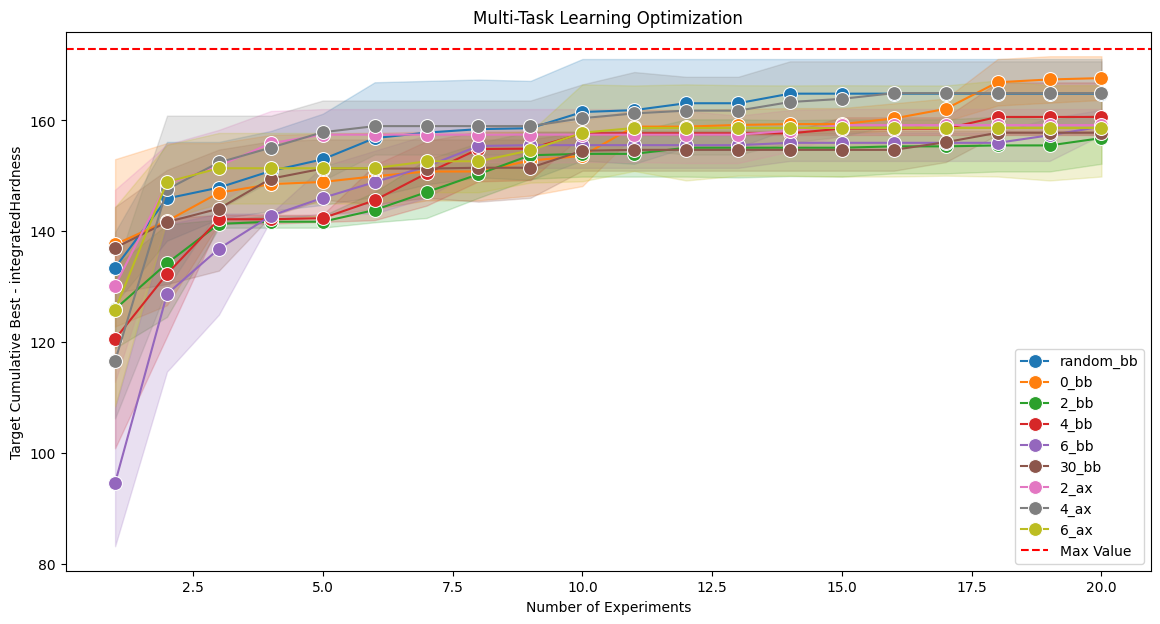

In [21]:
# add _bb to the end of the Number of data used column of dfResults_bb
dfResults_bb["Number of data used"] = dfResults_bb["Number of data used"].astype(str) + "_bb"
# add _ax to the end of the Number of data used column of dfResults_ax
dfResults_ax["Number of data used"] = dfResults_ax["Number of data used"].astype(str) + "_ax"

# concatenate dfResults_bb and dfResults_ax
dfResults_combined = pd.concat([dfResults_bb, dfResults_ax])
# %%
# intialize a subplot with 1 row and 1 column
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

# plot the results
ax = sns.lineplot(
    data=dfResults_combined,
    marker="o",
    markersize=10,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Number of data used",
)

# add a line at the maximum value
plt.axhline(y=dfLookupTable_target['Target'].max(), color='r', linestyle='--', label='Max Value')

# add a legend
plt.legend()

# add a title
plt.title("Multi-Task Learning Optimization")

# add a x-axis label
plt.xlabel("Number of Experiments")

# add a y-axis label
plt.ylabel("Target Cumulative Best - integratedHardness")